In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchsummary

### Dataset Preprocessing

In [4]:
img_transforms = transforms.Compose([transforms.RandomResizedCrop(224), 
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]) # ImageNet 데이터셋 기준 normalization
                                      ])

In [8]:
cifar10_train = datasets.CIFAR10(root="./data/", train=True, transform=img_transforms, download=True)
train_dataloader = torch.utils.data.DataLoader(cifar10_train, batch_size=64, shuffle=True, num_workers=2)

cifar10_test = datasets.CIFAR10(root="./data/", train=False, transform=img_transforms, download=True)
test_dataloader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:12<00:00, 13.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [18]:
images, labels = next(iter(train_dataloader))
print(images.size(), labels.size())

torch.Size([64, 3, 224, 224]) torch.Size([64])


### VGGNet Model

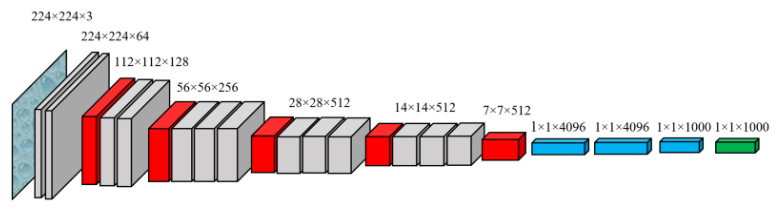

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
cfgs = {
    'vgg_11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg_13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg_16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg_19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [57]:
def conv_layer(cfgs):
    layers = []
    in_channels = 3

    for v in cfgs:
        if v == "M":
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(nn.Conv2d(in_channels, v, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = v

    return nn.Sequential(*layers)

In [63]:
class VGGNet(nn.Module):
    def __init__(self, config='vgg_11', num_classes=10):
        super(VGGNet, self).__init__()

        self.conv = conv_layer(cfgs[config])
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [69]:
model_16 = VGGNet(config='vgg_16').to(device)
torchsummary.summary(model_16, input_size=(3, 224, 224), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 224, 224]           1,792
              ReLU-2         [64, 64, 224, 224]               0
            Conv2d-3         [64, 64, 224, 224]          36,928
              ReLU-4         [64, 64, 224, 224]               0
         MaxPool2d-5         [64, 64, 112, 112]               0
            Conv2d-6        [64, 128, 112, 112]          73,856
              ReLU-7        [64, 128, 112, 112]               0
            Conv2d-8        [64, 128, 112, 112]         147,584
              ReLU-9        [64, 128, 112, 112]               0
        MaxPool2d-10          [64, 128, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]         295,168
             ReLU-12          [64, 256, 56, 56]               0
           Conv2d-13          [64, 256, 56, 56]         590,080
             ReLU-14          [64, 256,

In [71]:
model_19 = VGGNet(config='vgg_19').to(device)
torchsummary.summary(model_19, input_size=(3, 224, 224), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 224, 224]           1,792
              ReLU-2         [64, 64, 224, 224]               0
            Conv2d-3         [64, 64, 224, 224]          36,928
              ReLU-4         [64, 64, 224, 224]               0
         MaxPool2d-5         [64, 64, 112, 112]               0
            Conv2d-6        [64, 128, 112, 112]          73,856
              ReLU-7        [64, 128, 112, 112]               0
            Conv2d-8        [64, 128, 112, 112]         147,584
              ReLU-9        [64, 128, 112, 112]               0
        MaxPool2d-10          [64, 128, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]         295,168
             ReLU-12          [64, 256, 56, 56]               0
           Conv2d-13          [64, 256, 56, 56]         590,080
             ReLU-14          [64, 256,

### Train

In [76]:
model = VGGNet(config='vgg_11').to(device)

num_epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

In [80]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

Epoch [1/10] | Loss: 2.3026 | Acc: 10.00%
Epoch [2/10] | Loss: 2.3026 | Acc: 10.19%
Epoch [3/10] | Loss: 2.3024 | Acc: 10.29%
Epoch [4/10] | Loss: 2.3020 | Acc: 10.38%
Epoch [5/10] | Loss: 2.2998 | Acc: 13.40%
Epoch [6/10] | Loss: 2.2915 | Acc: 15.23%
Epoch [7/10] | Loss: 2.2649 | Acc: 16.26%
Epoch [8/10] | Loss: 2.2160 | Acc: 18.40%
Epoch [9/10] | Loss: 2.1626 | Acc: 20.02%
Epoch [10/10] | Loss: 2.1243 | Acc: 20.89%
